# Out-of-the-📦 FP8 Training

A demo of the `unit_scaling` library, showing how a model can be easily adapted to train in FP8.

💻 **Try the library**: [graphcore-research.github.io/unit-scaling](https://graphcore-research.github.io/unit-scaling/)

📖 **Read the paper**: [arxiv.org/abs/2303.11257](https://arxiv.org/abs/2303.11257)

In [ ]:
# Setup
!pip install -r requirements.txt

## TL;DR

Naïvely casting to FP8 causes training to fail as some values go out-of-range.
This can be easily fixed by using unit-scaled layers.

`unit_scaling` provides a transform to automatically unit-scale models (and another to simulate FP8 matmuls). We apply this to Karpathy's nanoGPT:

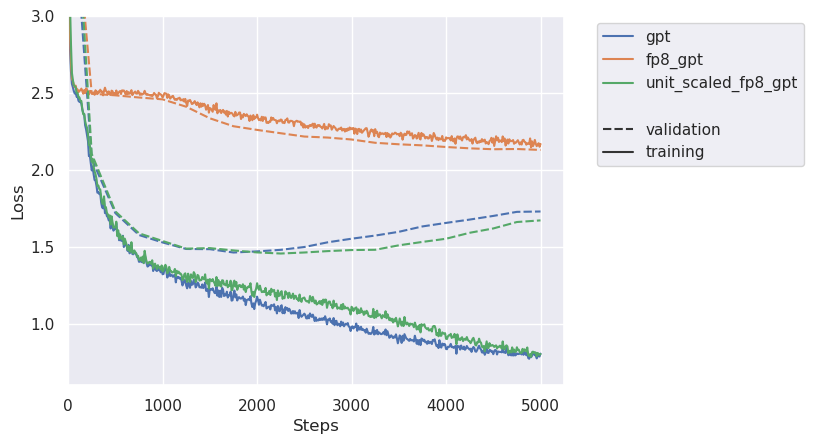

In [ ]:
from nanoGPT.model import GPT
from notebook_utils import config, train
from unit_scaling.transforms import simulate_fp8, unit_scale

gpt = GPT(config)  # model unchanged from original nanoGPT
fp8_gpt = simulate_fp8(gpt)
unit_scaled_fp8_gpt = unit_scale(fp8_gpt)

models = [gpt, fp8_gpt, unit_scaled_fp8_gpt]
for model in models:
    train(model)

We see that training the base model directly in FP8 causes a significant degradation. Full accuracy can then be recovered by applying the unit scaling transform.

This transform can be applied to arbitrary PyTorch models, with negligible overhead when used with `torch.compile`*. For users who don't wish to use the automatic transform, unit-scaling can also be implemented manually**.

What follows is a step-by-step guide on the problem of naïvely running in FP8, and how `unit_scaling` addresses it.

*_see our [Benchmarking Compiled Unit-Scaled Ops](https://github.com/graphcore-research/unit-scaling/blob/main/analysis/benchmarking_compiled_unit_scaled_ops.ipynb) notebook for a full analysis of the (lack of) overhead when using `unit_scaling`._

**_see our [User Guide](https://graphcore-research.github.io/unit-scaling/user_guide) for details on how to manually implement unit scaling. This largely consists of swapping regular PyTorch modules & functions for their unit-scaled equivalents in the library._

---

## Why use FP8?

Floating point numbers comprise three parts: a sign bit, exponent bits (providing range) and mantissa bits (providing precision). Initial deep learning models used 32-bit floating-point representations (FP32), later shifting to 16-bits (FP16/BF16) for most operations to improve efficiency.

Two standards have recently been proposed for 8-bit floating-point formats ([1](https://www.graphcore.ai/posts/graphcore-and-amd-propose-8-bit-fp-ai-standard-with-qualcomm-support),[2](https://developer.nvidia.com/blog/nvidia-arm-and-intel-publish-fp8-specification-for-standardization-as-an-interchange-format-for-ai/)), both of which use a 4-bit exponent version (FP8 E4) for activations and weights, and a 5-bit exponent version (FP8 E5) for gradients. The latest generation of deep learning accelerators (such as Graphcore's [C600](https://www.graphcore.ai/products/c600) or Nvidia's [H100](https://www.nvidia.com/en-gb/data-center/h100/)) provide specialised hardware to accelerate FP8 matrix-multiplications, typically giving double the FLOP/s of 16-bit formats.

Research ([3](https://arxiv.org/abs/2206.02915),[4](https://arxiv.org/abs/2209.05433)) has shown that it's possible to train using FP8 matmuls without degradation. However, the obvious approach of simply inserting a cast before each matmul is not sufficient.

(for a more detailed overview of the different number formats, see [this visualisation](https://thecharlieblake.co.uk/visualising-ml-number-formats))

## The problem with naïve FP8 Training

We'll demonstrate this using Andrej Karpathy's popular [NanoGPT](https://github.com/karpathy/nanoGPT) model. We simulate the use of FP8 here using the `simulate_fp8()` wrapper provided by `unit_scaling.transforms`. This identifies every matmul in the forward and backward passes and quantises them to the representable values in the appropriate FP8 format.

Note that we use *simulated* FP8 here rather than relying on FP8 hardware, as this notebook is intended as a demo. The `unit_scaling` library does not yet contain cast operations that run on FP8 hardware, so for now we keep tensors in higher precision, rounding values to those provided by FP8 without actually changing the underlying dtype.

Let's now train the original FP32 GPT model, alongside a second model which inserts these "naïve" FP8 casts:

In [1]:
from nanoGPT.model import GPT
from notebook_utils import config, train
from unit_scaling.transforms import simulate_fp8

gpt = GPT(config)  # model unchanged from original nanoGPT
fp8_gpt = simulate_fp8(gpt)

models = [gpt, fp8_gpt]
for model in models:
    train(model)

/Users/charlieb/Projects/graphcore/free-fp8-training/.venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/charlieb/Projects/graphcore/free-fp8-training/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


number of parameters: 10.67M


We can see that simply inserting FP8 casts before matmuls causes a significant degradation. Why is this the case, and how can we do better?

To answer these questions the unit scaling library provides a `unit_scaling.visualiser` tool (TODO: update lib naming), designed to facilitate the analysis of scale within models. It uses PyTorch 2.0's [TorchDynamo compiler](https://pytorch.org/docs/stable/dynamo/index.html) to capture the model-graph, which is then visualised in terms of the scale of each tensor.

By running the visualiser on the (untrained) base model, the problem with these FP8 casts becomes evident:

number of parameters: 10.67M


<Axes: title={'center': 'gpt'}, xlabel='mean absolute value', ylabel='layer'>

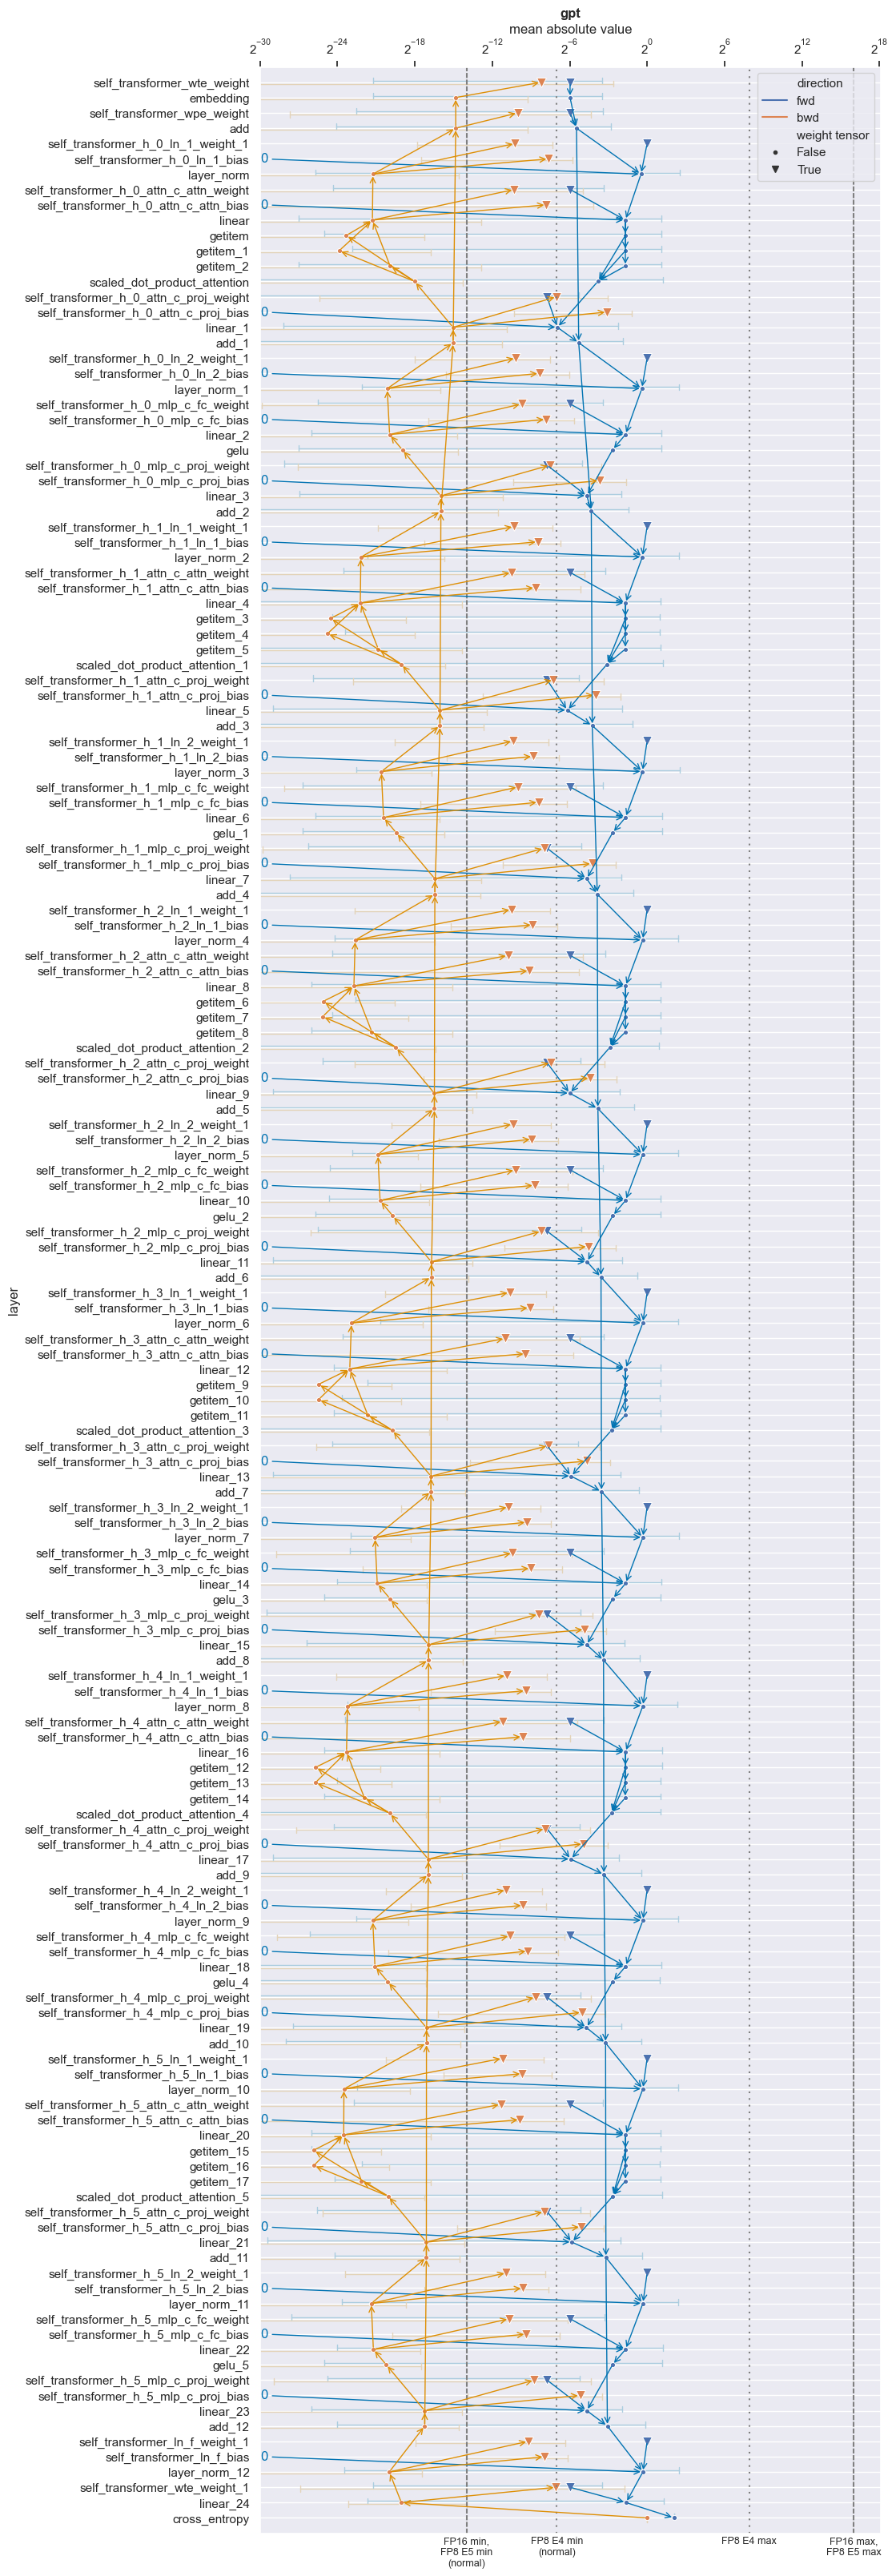

In [2]:
from unit_scaling import visualiser
from notebook_utils import NanoGPTTokenizer

visualiser(
    model=GPT(config),
    tokenizer=NanoGPTTokenizer(),
    batch_size=config.batch_size,
    seq_len=config.block_size,
    title="gpt",
    xmin=2**-30,
)

Problem clear from model even at initialisation
Explain what this particular plot represents in terms of numerics, and why naive FP8 fails
Begin to suggest what property we would want from plot in ideal case (leading into...)

## How unit scaling fixes things

[TODO]

1. Explain unit scaling method
2. Show how it would be implemented manually
3. Show the wrapper and explain how it works (with caveats)
4. Explain benefits vs other approaches and lack of overheads
5. Re-show plot with all 3 results
6. Show scales post-training?

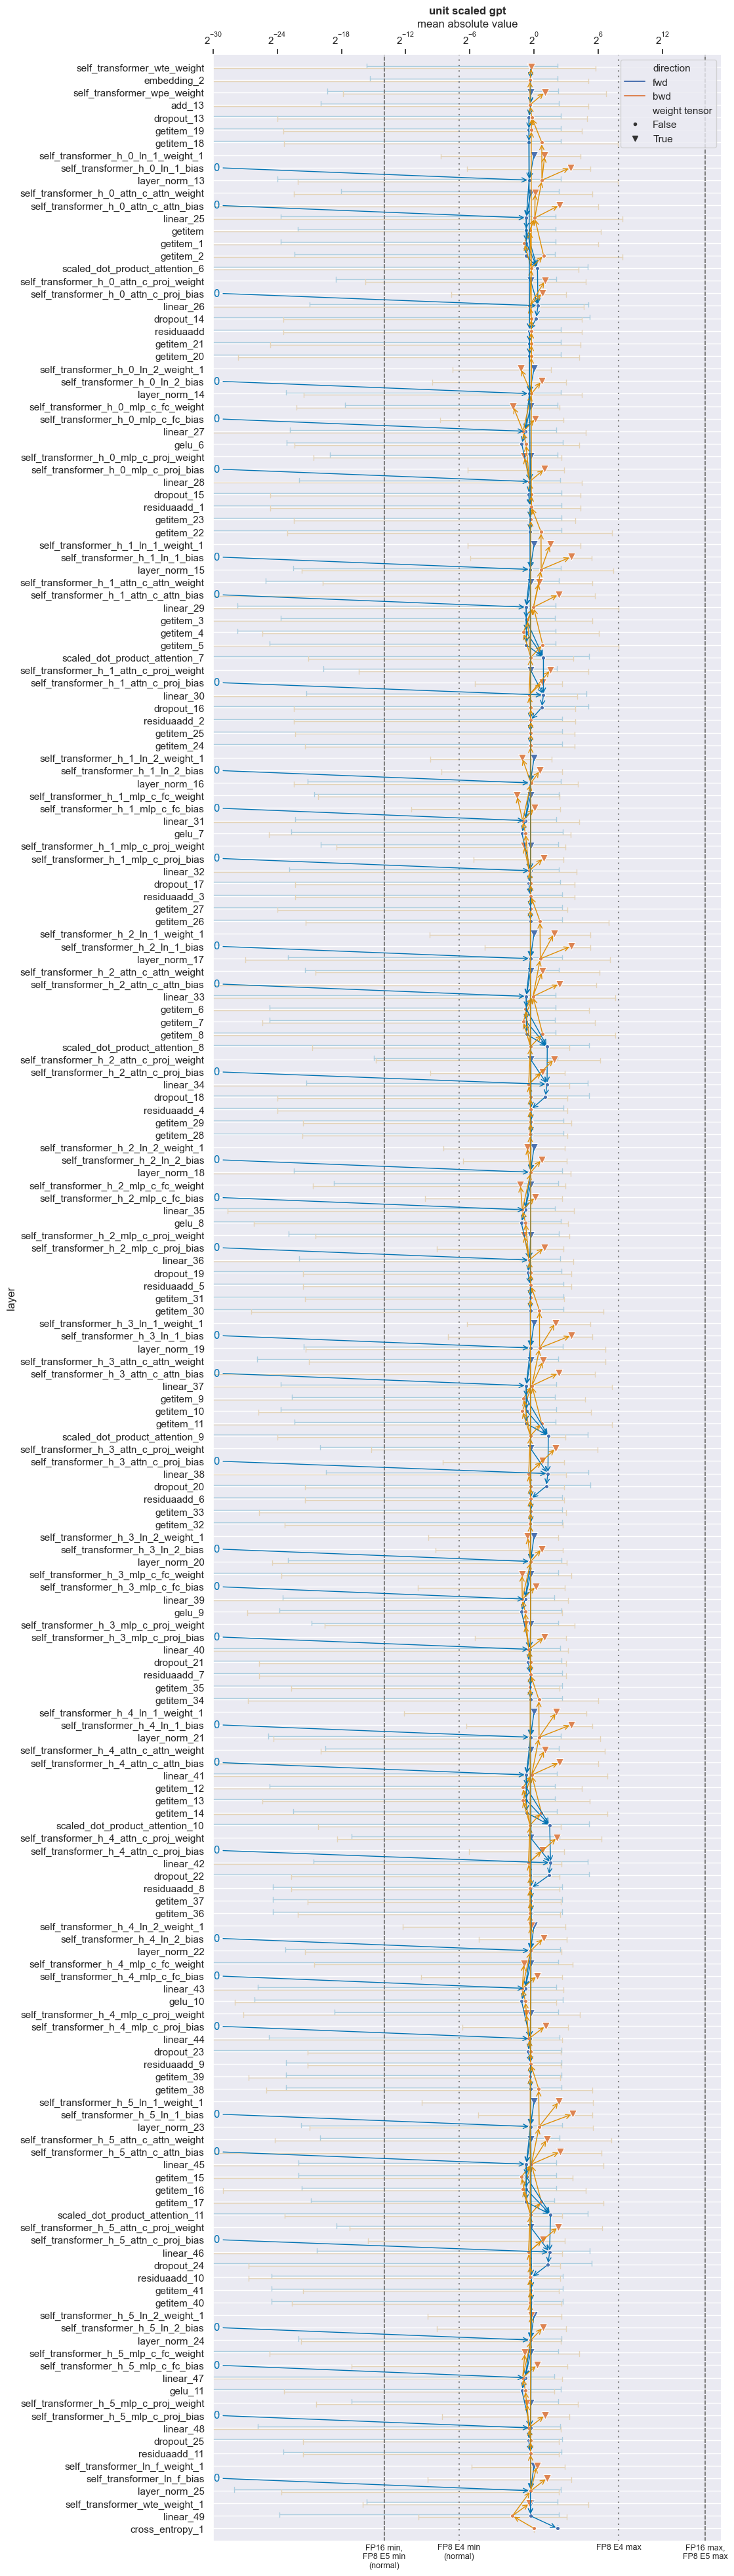

In [4]:
from unit_scaling.transforms import unit_scale

visualiser(
    model=unit_scale(GPT(config)),
    tokenizer=NanoGPTTokenizer(),
    batch_size=config.batch_size,
    seq_len=config.block_size,
    title="unit scaled gpt",
    xmin=2**-30,
)

## Takeaways

[TODO] Conclusion encouraging users to try unit-scaled training; offering our support; warn that there will be bugs / missing features

(also mention somewhere costs of doing US - i.e. none. We maybe should add in compile transform too. Not sure if it's too small-scale here to benefit. Either way - we should point users to our scale-fusion analysis notebook)